In [1]:
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
import pyidi                    # Python HSC data analysis library
import pickle as pk
import os
from pixel_setter2 import PixelSetter#, play_video, detect_peaks
from pixel_setter import play_video
from skimage import feature, measure
import importlib
from EMA_functions import *
import matplotlib.animation as animation
# from scipy.signal import convolve2d
from scipy.ndimage import generic_filter
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Import video

In [2]:
# file_root = r'G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Spiders/Other/Blackledge_media'
# file_name = "Full_web_ecc0_new_Floc4_v1" # First attempt
# file_name_vec = ['Full_web_ecc0_new_Floc9_v0', 
#                  'Full_web_ecc0_new_Floc9_v1', 
#                  'Full_web_ecc1_new_Floc1_v4',
#                  'Full_web_ecc1_new_Floc1_v5',
#                  'Full_web_ecc2_new_Floc7_v0',
#                  'Full_web_ecc2_new_Floc7_v1']
# file_name = file_name_vec[0]
file_name = 'Full_web_ecc2_new2_Floc18_v0'
# folder_paths = ['H:/My Drive/PHD/HSC', 'D:/HSC', 'F:/', 'E:/thijs/', 'C:/Users/thijs/Documents/HSC/', 'D:/thijsmas/HSC']
# file_name = 'Ar.tri.22.01-128stab-10.19.2021.mov'
EMA_structure = EMA_Structure(file_name)
video = EMA_structure.open_video()

H:/My Drive/PHD/HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v0_S01\Full_web_ecc2_new2_Floc18_v0_S01.cihx


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 8000, Original total frame: 87371)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


### Plot still frame in video

In [3]:
%matplotlib qt
sequential_image_n = 0
still_image = video.mraw[sequential_image_n]

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False)
fig.savefig(os.path.join(root_drive_sim, 'still images', f'{file_name}_frame_sat0.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=True)
fig.savefig(os.path.join(root_drive_sim, 'still images','with saturation', f'{file_name}_frame_sat1.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

first_frame = 1
ani = play_video(video, range(first_frame,video.N), interval=30)

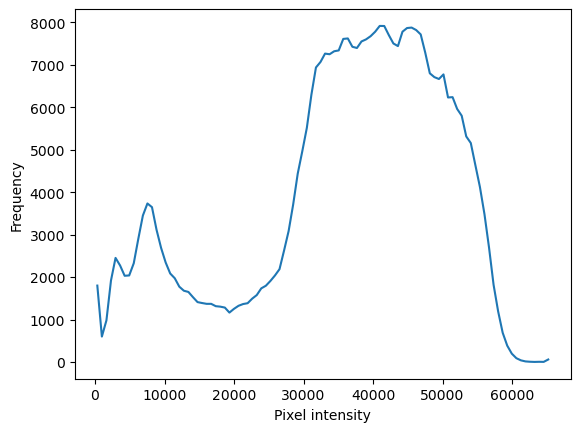

In [4]:
get_PI_histogram(still_image, remove_sides_fraction=0.1, save_path=os.path.join(root_drive_sim, 'histograms'), save_name=f'{file_name}_histogram.png')

In [5]:
reference_image = (0, 100)
roi_size        = (3, 3)
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)
mean_image_copy = mean_image.copy()
background_pixels = mean_image > 0.3 * np.max(mean_image)
mean_image_copy[background_pixels] = np.max(mean_image_copy)
fig, ax = plt.subplots(2,1)
ax[0].imshow(mean_image, cmap='gray')
ax[1].imshow(mean_image_copy, cmap='gray')
plt.show()

### Set pixels

In [6]:
pix_set = PixelSetter(still_image, file_name = file_name)
eig_img = pix_set.find_eigenvalue_image(mean_image, roi_size[0], method = 'on_gradient') #'on_gradient'

In [7]:
eig_tracking_points= pix_set.tp_from_eig_img(size = 6, background_threshold = 0.4, local_max_treshold=0.3, exlude_sides_factor=.15, show=True)


In [8]:
pix_set.set_neighborhood_size(4)
pix_set.choose_reference_centers(include_eig_tp=True)

### Combine the tracking points and exclude erroneous points

In [9]:
pix_set.combine_tracking_points()
tp = np.array(list(pix_set.tracking_points))
center = np.array(still_image.shape[:2])/2
center[1] = center[1] - 20
center[0] = center[0] - 40
radius = 0.88*np.linalg.norm(center)
distances = np.linalg.norm(tp - center, axis=1)
inside_web = (distances < radius)
hor_section = (tp[:, 1] > 2) & (tp[:, 1] < 1100)
ver_section = (tp[:, 0] > 15) & (tp[:, 0] < 490)
tp_lim = tp#tp[hor_section & ver_section & inside_web]

fig, ax = plt.subplots(figsize=(10, 10))

# plot tp
plt.scatter(center[1], center[0])
plt.scatter(tp[:, 1], tp[:, 0], c='red', s=10, label='tp')

# plot tp_lim with markers on top of tp
plt.scatter(tp_lim[:, 1], tp_lim[:, 0], c='green', s=5, label='tp_lim')
ax.set_xlim([0, still_image.shape[1]])
ax.set_ylim([still_image.shape[0] , 0])
ax.axis('equal')
# show the plot
plt.show()


### Save or open tracking points

In [10]:
np.savetxt(os.path.join(root_drive_sim, 'tp', f'tp_{file_name}.txt'), tp, fmt='%.18e', delimiter=',')
# tp = np.loadtxt(os.path.join(root_drive_sim, 'tp', f'tp_{file_name}.txt'), delimiter=',')

In [11]:
v_vec = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
# v_vec = [0]
roi_size = (9,9)
reference_image = (0, 30)
# mraw_range = (1, 1000)
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'

for v in v_vec:
    file_name = 'Full_web_ecc2_new2_Floc18_v' + str(v)
    tp = np.loadtxt(os.path.join(root_drive_sim, 'tp', f'tp_{file_name}.txt'), delimiter=',')
    EMA_structure = EMA_Structure(file_name)
    video = EMA_structure.open_video()
    video.set_method('lk')
    video.method.configure(roi_size=roi_size, reference_image=reference_image) #, mraw_range=mraw_range
    video.set_points(tp)
    path = os.path.join(root, file_name+f'_d_rs{str(roi_size)}_ri{str(reference_image)}'+'.pkl')
    d = video.get_displacements(processes = 16, resume_analysis = False)
    with open(path, 'wb') as f:
        pk.dump({'displacement':d, 'tracking points': tp}, f)



H:/My Drive/PHD/HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v0_S01\Full_web_ecc2_new2_Floc18_v0_S01.cihx


In [17]:
start_time = time.time()
video.method.configure(roi_size=(11,11), reference_image=reference_image)
d = video.get_displacements(processes=1, resume_analysis=False)
end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

--- Starting new analysis ---
 
Interpolating the reference image...
...done in 0.04 s


VBox()

Time to complete: 1 min, 12.3 s
H:/My Drive/PHD/HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v0_S01\Full_web_ecc2_new2_Floc18_v0_S01_pyidi_analysis\analysis_004\ analysis_004
Execution time: 72.31047534942627 seconds


In [ ]:
import pickle

file_path = r'H:\My Drive\PHD\HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v0_S01\temp_file\settings.pkl'

with open(file_path, 'rb') as f:
    settings = pickle.load(f)

# Now you can use the 'settings' variable to access the data in the file
settings

In [202]:
import time
import numpy as np
def compute_inverse_numba(Gx, Gy):
    Gx2 = np.sum(Gx**2)
    Gy2 = np.sum(Gy**2)
    GxGy = np.sum(Gx * Gy)
    A_inv = 1/(GxGy**2 - Gx2*Gy2) * np.array([[GxGy, -Gx2], [-Gy2, GxGy]])
    return A_inv

def compute_delta_numba(F, G, Gx, Gy, A_inv):
    F_G = G - F
    b = np.array([np.sum(Gx*F_G), np.sum(Gy*F_G)])
    delta = np.dot(A_inv, b)

    error = np.sqrt(np.sum(delta**2))
    return delta, error

steps_till_convergence = 10

n = 15
reduce = 4

Af = np.zeros((n**2))
im1_f = np.zeros((n-reduce, n-reduce))
im2_f = np.zeros((n-reduce, n-reduce))
G_float_clipped_new = np.zeros((n-reduce, n-reduce))
F_clipped_new = np.zeros((n-reduce, n-reduce))

time_full_total = 0
time_partial_total = 0
total_steps = 1000

for it in range(total_steps):
    A = np.random.randint(0, 10, (n+2, n+2))
    F = np.random.randint(0, 10, (n, n))
    include = True * np.ones((n,n), dtype=bool)
    include_expanded = np.pad(include, ((1, 1), (1, 1)), mode='constant', constant_values=False)

    num_elements = n**2
    num_false = n**2 - (n-reduce)**2
    indices = np.random.choice(num_elements, num_false, replace=False)
    include.flat[indices] = False
    i, j = np.where(include)
    i_plus1 = i + 1
    i_plus2 = i + 2
    j_plus1 = j + 1
    j_plus2 = j + 2
    flat_index00 = np.ravel_multi_index((i, j), (n,n), order='C')
    flat_index01 = np.ravel_multi_index((i, j_plus1), (n+2,n+2), order='C')
    flat_index10 = np.ravel_multi_index((i_plus1, j), (n+2,n+2), order='C')
    flat_index21 = np.ravel_multi_index((i_plus2, j_plus1), (n+2,n+2), order='C')
    flat_index12 = np.ravel_multi_index((i_plus1, j_plus2), (n+2,n+2), order='C')
    # flat_index11 = np.ravel_multi_index((i_plus1, j_plus1), (n+2,n+2), order='C')


    # ORIGNAL IMPLEMENTATION
    start_time = time.time()
    im1 = A[2:, 1:-1]
    im2 = A[:-2, 1:-1]
    Gy_full = (im1 - im2)/2

    im1 = A[1:-1, 2:]
    im2 = A[1:-1, :-2]
    Gx_full = (im1 - im2)/2
    A_inv = compute_inverse_numba(Gx_full, Gy_full)
    G_float_clipped = A[1:-1, 1:-1]
    for i in range(steps_till_convergence):
        delta, error = compute_delta_numba(F, G_float_clipped, Gx_full, Gy_full, A_inv)

    end_time = time.time()
    time_full = end_time - start_time
    time_full_total += time_full

    # NEW IMPLEMENTATION
    start_time = time.time()
    # Af = A.flat
    im1_f.flat = A.flat[flat_index21]
    im2_f.flat = A.flat[flat_index01]
    Gy = (im1_f - im2_f)/2

    im1_f.flat = A.flat[flat_index12]
    im2_f.flat = A.flat[flat_index10]
    Gx = (im1_f - im2_f)/2
    A_inv = compute_inverse_numba(Gx, Gy)
    G_float_clipped_new.flat = A.flat[flat_index00]
    F_clipped_new.flat = F.flat[flat_index00]
    for i in range(steps_till_convergence):
        delta, error = compute_delta_numba(F_clipped_new, G_float_clipped_new, Gx, Gy, A_inv)
    end_time = time.time()

    time_partial = end_time - start_time
    time_partial_total += time_partial

# np.reshape(Gy_full[:, 1:-1][include], (n-1,n-1)), Gy
result = np.array_equal(np.reshape(Gy_full[include], (n-reduce, n-reduce)), Gy)
time_full_total, time_partial_total, result


(0.44649696350097656, 0.47519350051879883, True)

In [137]:
import numpy as np

# Create a larger matrix
larger_matrix = np.array([[1, 2, 3, 4],
                          [5, 6, 7, 8],
                          [9, 10, 11, 12],
                          [13, 14, 15, 16]])

# Create a boolean mask indicating which elements to include
bool_mask = np.array([[False, True, False, True],
                      [True, False, True, False],
                      [False, True, False, True],
                      [True, False, True, True]])

# Create a boolean array of the same shape as the larger matrix
output_mask = np.zeros_like(larger_matrix, dtype=bool)

# Set the elements in the boolean array based on the boolean mask
output_mask[bool_mask] = True

# Use boolean indexing to extract the relevant elements
smaller_matrix = larger_matrix[output_mask]

print("Larger Matrix:")
print(larger_matrix)

print("\nSmaller Matrix:")
print(smaller_matrix)

Larger Matrix:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Smaller Matrix:
[ 2  4  5  7 10 12 13 15 16]


In [ ]:

# mraw_range = (sequential_image_n+1, 500)
# reference_image = (0, 30)
# roi_size_vec = [(3, 3), (5,5), (7, 7), (9, 9), (11, 11), (13, 13)]
# roi_size = (11, 11)
# video.method.configure(reference_image = reference_image, roi_size= roi_size)
# video.show_points()

d = video.get_displacements(processes = 1) #processes = -1
d = video.displacements

root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, file_name+f'_d_rs{str(roi_size)}_ri{str(reference_image)} - round'+'.pkl')
with open(path, 'wb') as f:
    pk.dump({'displacement':d, 'tracking points': tp_lim}, f)

dd = np.diff(d, axis=1)
last_10_zeros = np.any(dd[:, -10:, :] == 0, axis=(1,2))
large_d = np.any(np.linalg.norm(d, axis=2) > 10, axis = 1)
good_points = np.logical_not(last_10_zeros | large_d)

first_frame = 1

td = d +  tp_lim.reshape(len(tp_lim),1,2)
ani = play_video(video, range(first_frame+2000, video.N-1), interval=30, points=td[good_points, first_frame:, :])
writer = animation.FFMpegWriter(fps=60)
ani.save(os.path.join(root_drive_sim,'anim', f'{file_name}_d_rs{str(roi_size)}_ri{str(reference_image)}_anim_round_.mp4'), writer=writer)

In [ ]:
d = video.get_displacements(processes = 12)
# video.method.valid_points
d = video.displacements

### Save or open displacements and tracking points

In [ ]:
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, file_name+f'_d_rs{str(roi_size)}_ri{str(reference_image)}'+'.pkl')
with open(path, 'wb') as f:
    pk.dump({'displacement':d, 'tracking points': tp}, f)

### Animate the results

In [ ]:
%matplotlib qt
dd = np.diff(d, axis=1)
last_10_zeros = np.any(dd[:, -10:, :] == 0, axis=(1,2))
large_d = np.any(np.linalg.norm(d, axis=2) > 10, axis = 1)
good_points = np.logical_not(last_10_zeros | large_d)

first_frame = 2000

td = d +  tp.reshape(len(tp),1,2)
ani = play_video(video, range(first_frame, video.N-1), interval=30, points=td[:, 1:, :])
# writer = animation.FFMpegWriter(fps=60)
# ani.save(os.path.join(root_drive_sim,'anim', f'{file_name}_d_rs{str(roi_size)}_ri{str(reference_image)}_anim_.mp4'), writer=writer)

### Plot signals

In [ ]:
fig, ax = plt.subplots()
for point in np.arange(d.shape[0])[good_points][::5]: #[video.method.valid_points]
    ax.plot(np.arange(video.N), d[point, :, 0], label='point {} - dir 0'.format(point)) #video.info['Record Rate(fps)']*
    ax.plot(np.arange(video.N), d[point, :, 1], label='point {} - dir 1'.format(point)) #video.info['Record Rate(fps)']*
# ax.legend()
# ax.set_ylim(-50, 50)
ax.set_xlabel('frame number')
ax.set_ylabel('displacement [pixels]')